# Pattern Matching Experiments

In [1]:
from DSGRN import *

# Networks

We give two sets of networks. One of them allows for all parameters. The other is identical except it only uses essential parameters.

In [2]:
network_strings = [ 
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : HCM1", "YOX1 : SWI4"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : HCM1", "YOX1 : (SWI4)(HCM1)"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : HCM1", "YOX1 : (SWI4)(~HCM1)"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : HCM1", "YOX1 : (SWI4)(NDD1)"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : HCM1", "YOX1 : (SWI4)(~NDD1)"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : (SWI4)(YOX1)", "NDD1 : HCM1", "YOX1 : SWI4"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : (SWI4)(~YOX1)", "NDD1 : HCM1", "YOX1 : SWI4"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : (HCM1)(YOX1)", "YOX1 : SWI4"],
["SWI4 : (NDD1)(~YOX1)", "HCM1 : SWI4", "NDD1 : (HCM1)(~YOX1)", "YOX1 : SWI4"] ]

## Full Networks

In [3]:
networks = [Network() for i in range(0,9)]
for i,network in enumerate(networks):
    network.assign('\n'.join(network_strings[i]))

## Essential Networks

In [4]:
essential_network_strings = [ [ line + " : E" for line in network_string ] for network_string in network_strings]
essential_networks = [Network() for i in range(0,9)]
for i,network in enumerate(essential_networks):
    network.assign('\n'.join(essential_network_strings[i]))

# Path match analysis

We give two functions for path match analysis. One looks at the entire domain graph. The other only checks for path matches in stable Morse sets.

## Analysis on entire domain graph

In [5]:
def Analyze(network, events, event_ordering):
    poe = PosetOfExtrema(network, events, event_ordering )
    pattern_graph = PatternGraph(poe)
    parameter_graph = ParameterGraph(network)
    result = []
    for parameter_index in range(0, parameter_graph.size()):
        parameter = parameter_graph.parameter(parameter_index)
        search_graph = SearchGraph(DomainGraph(parameter))
        matching_graph = MatchingGraph(search_graph, pattern_graph);
        if PathMatch(matching_graph):
            result.append(parameter_index)
    return [result,  parameter_graph.size()]

## Analysis on stable Morse set only

In [6]:
def AnalyzeOnStable(network, events, event_ordering):
    poe = PosetOfExtrema(network, events, event_ordering )
    pattern_graph = PatternGraph(poe)
    parameter_graph = ParameterGraph(network)
    results = []
    for parameter_index in range(0, parameter_graph.size()):
        parameter = parameter_graph.parameter(parameter_index)
        domain_graph = DomainGraph(parameter)
        morse_decomposition = MorseDecomposition(domain_graph.digraph())
        morse_graph = MorseGraph()
        morse_graph.assign(domain_graph, morse_decomposition)
        MorseNodes = range(0, morse_graph.poset().size())
        isStable = lambda node : len(morse_graph.poset().children(node)) == 0
        isStableFC = lambda node : morse_graph.annotation(node)[0] == 'FC' and isStable(node)
        hasStableFC = any( isStableFC(node) for node in MorseNodes)
        StableNodes = [ node for node in MorseNodes if isStable(node) ]
        subresult = []
        for node in StableNodes:
            search_graph = SearchGraph(domain_graph, node)
            matching_graph = MatchingGraph(search_graph, pattern_graph)
            path_match = PathMatch(matching_graph)
            if path_match:
                subresult.append([parameter_index, node])
        results.append([subresult, 1 if hasStableFC else 0])
    return [results, parameter_graph.size()]

# Poset of Extrema

We study two poset of extrema. The first poset comes from looking at times [10,60] and assuming SWI4 happens before the other minima at the beginning and thus can be excluded. The other comes from including all extrema.

## Original Poset of Extrema

In [7]:
original_events = [("HCM1", "min"), ("NDD1", "min"), ("YOX1", "min"), 
          ("SWI4", "max"), ("HCM1", "max"), ("YOX1", "max"), 
          ("NDD1", "max"),
          ("SWI4","min")]
original_event_ordering = [ (i,j) for i in [0,1,2] for j in [3,4,5] ] + \
                 [ (i,j) for i in [3,4,5] for j in [6] ] + \
                 [ (i,j) for i in [6] for j in [7] ]

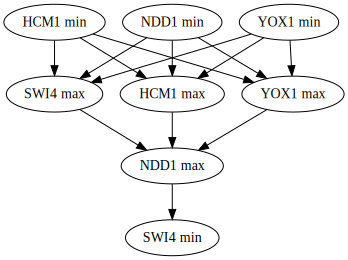

In [8]:
DrawGraph(PosetOfExtrema(networks[0], original_events, original_event_ordering ))

## Alternative Poset of Extrema

In [9]:
all_events = [("SWI4", "min"), ("HCM1", "min"), ("NDD1", "min"), ("YOX1", "min"), 
          ("SWI4", "max"), ("HCM1", "max"), ("YOX1", "max"), 
          ("NDD1", "max"),
          ("SWI4","min"),
          ("YOX1", "min"), ("HCM1","min"),
          ("NDD1", "min"),
          ("SWI4", "max"), ("HCM1", "max"), ("YOX1", "max"),
          ("NDD1", "max")]
all_event_ordering = [ (i,j) for i in [0,1,2,3] for j in [4,5,6] ] + \
                 [ (i,j) for i in [4,5,6] for j in [7] ] + \
                 [ (i,j) for i in [7] for j in [8] ] + \
                 [ (i,j) for i in [8] for j in [9,10] ] + \
                 [ (i,j) for i in [9,10] for j in [11,12,13,14] ] + \
                 [ (11,15) ]

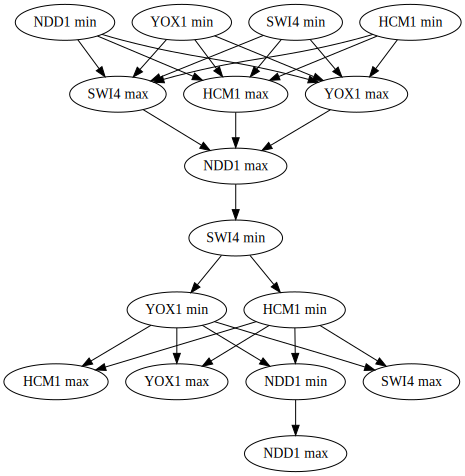

In [10]:
DrawGraph(PosetOfExtrema(networks[0], all_events, all_event_ordering ))

# Experiments

There are 8 experiements corresponding to 3 binary choices:

* Full networks vs Essential networks 
* Path matching in entire domain graph vs path matching in stable Morse sets
* Original poset of extrema vs Alternative poset of extrema


In [11]:
def DisplayExperiment(results, title):
    markdown_string = "# " + title + "\n\n"
    markdown_string += "| network | # parameters | # parameters with path match |\n"
    markdown_string += "| ------- |------------ | ---------------------------- |\n"
    for i, item in enumerate(results):
        [parameters_with_path_match, pgsize] = item
        markdown_string += ("|" + str(i) + "|" + str(pgsize) + "|" + str(len(parameters_with_path_match)) + "|\n")
    from IPython.display import display, Markdown, Latex
    display(Markdown(markdown_string))
def DisplayStableExperiment(results, title):
    markdown_string = "# " + title + "\n\n"
    markdown_string += "| network | # parameters | # parameters with stable FC | # parameters with path match |\n"
    markdown_string += "| ------- |------------ | ---------------------------- | ---------------------------- |\n"
    for i, item in enumerate(results):
        [results, pgsize] = item
        parameters_with_path_match = sum([ 1 if pair[0] else 0 for pair in results])
        parameters_with_stable_fc = sum([ 1 if pair[1] else 0 for pair in results])
        markdown_string += ("|" + str(i) + "|" + str(pgsize) + "|" +str(parameters_with_stable_fc) +"|"+str(parameters_with_path_match) + "|\n")
    from IPython.display import display, Markdown, Latex
    display(Markdown(markdown_string))

In [12]:
%%time
experiment = lambda network : Analyze(network, original_events, original_event_ordering)
experimental_results_1 = [ experiment(network) for network in networks ]
DisplayExperiment(experimental_results_1, "Experiment 1: All parameters, original poset of extrema")

# Experiment 1: All parameters, original poset of extrema

| network | # parameters | # parameters with path match |
| ------- |------------ | ---------------------------- |
|0|1080|22|
|1|8640|316|
|2|8640|180|
|3|8640|226|
|4|8640|280|
|5|8640|176|
|6|8640|270|
|7|8640|176|
|8|8640|176|


CPU times: user 12.9 s, sys: 63.4 ms, total: 13 s
Wall time: 13.1 s


In [13]:
%%time
experiment = lambda network : Analyze(network, original_events, original_event_ordering)
experimental_results_2 = [ experiment(network) for network in essential_networks ]
DisplayExperiment(experimental_results_2, "Experiment 2: Essential parameters, original poset of extrema")

# Experiment 2: Essential parameters, original poset of extrema

| network | # parameters | # parameters with path match |
| ------- |------------ | ---------------------------- |
|0|14|8|
|1|56|38|
|2|56|18|
|3|56|25|
|4|56|28|
|5|56|16|
|6|56|30|
|7|56|24|
|8|56|24|


CPU times: user 94.8 ms, sys: 3.15 ms, total: 97.9 ms
Wall time: 96.6 ms


In [14]:
%%time
experiment = lambda network : AnalyzeOnStable(network, original_events, original_event_ordering)
experimental_results_3 = [ experiment(network) for network in networks ]
DisplayStableExperiment(experimental_results_3, "Experiment 3: All parameters, original poset, stable only")

# Experiment 3: All parameters, original poset, stable only

| network | # parameters | # parameters with stable FC | # parameters with path match |
| ------- |------------ | ---------------------------- | ---------------------------- |
|0|1080|4|16|
|1|8640|56|224|
|2|8640|24|96|
|3|8640|132|166|
|4|8640|36|108|
|5|8640|56|128|
|6|8640|168|222|
|7|8640|48|118|
|8|8640|108|134|


CPU times: user 8.8 s, sys: 25.5 ms, total: 8.82 s
Wall time: 8.83 s


In [15]:
%%time
experiment = lambda network : AnalyzeOnStable(network, original_events, original_event_ordering)
experimental_results_4 = [ experiment(network) for network in essential_networks ]
DisplayStableExperiment(experimental_results_4, "Experiment 4: Essential parameters, original poset, stable only")

# Experiment 4: Essential parameters, original poset, stable only

| network | # parameters | # parameters with stable FC | # parameters with path match |
| ------- |------------ | ---------------------------- | ---------------------------- |
|0|14|2|2|
|1|56|8|8|
|2|56|0|0|
|3|56|8|7|
|4|56|0|0|
|5|56|8|4|
|6|56|28|18|
|7|56|8|8|
|8|56|28|18|


CPU times: user 93.6 ms, sys: 4.17 ms, total: 97.8 ms
Wall time: 95.9 ms


In [16]:
%%time
experiment = lambda network : Analyze(network, all_events, all_event_ordering)
experimental_results_5 = [ experiment(network) for network in networks ]
DisplayExperiment(experimental_results_5, "Experiment 5: All parameters, alternative poset of extrema")

# Experiment 5: All parameters, alternative poset of extrema

| network | # parameters | # parameters with path match |
| ------- |------------ | ---------------------------- |
|0|1080|22|
|1|8640|264|
|2|8640|176|
|3|8640|224|
|4|8640|278|
|5|8640|176|
|6|8640|268|
|7|8640|176|
|8|8640|176|


CPU times: user 11 s, sys: 16.7 ms, total: 11 s
Wall time: 11 s


In [17]:
%%time
experiment = lambda network : Analyze(network, all_events, all_event_ordering)
experimental_results_6 = [ experiment(network) for network in essential_networks ]
DisplayExperiment(experimental_results_6, "Experiment 6: Essential parameters, alternative poset of extrema")

# Experiment 6: Essential parameters, alternative poset of extrema

| network | # parameters | # parameters with path match |
| ------- |------------ | ---------------------------- |
|0|14|8|
|1|56|32|
|2|56|16|
|3|56|24|
|4|56|28|
|5|56|16|
|6|56|28|
|7|56|24|
|8|56|24|


CPU times: user 88.7 ms, sys: 3.88 ms, total: 92.6 ms
Wall time: 91.1 ms


In [18]:
%%time
experiment = lambda network : AnalyzeOnStable(network, all_events, all_event_ordering)
experimental_results_7 = [ experiment(network) for network in networks ]
DisplayStableExperiment(experimental_results_7, "Experiment 7: All parameters, alternative poset of extrema, stable only")

# Experiment 7: All parameters, alternative poset of extrema, stable only

| network | # parameters | # parameters with stable FC | # parameters with path match |
| ------- |------------ | ---------------------------- | ---------------------------- |
|0|1080|4|16|
|1|8640|56|192|
|2|8640|24|96|
|3|8640|132|164|
|4|8640|36|108|
|5|8640|56|128|
|6|8640|168|221|
|7|8640|48|118|
|8|8640|108|134|


CPU times: user 9.23 s, sys: 33.6 ms, total: 9.26 s
Wall time: 9.27 s


In [19]:
%%time
experiment = lambda network : AnalyzeOnStable(network, all_events, all_event_ordering)
experimental_results_8 = [ experiment(network) for network in essential_networks ]
DisplayStableExperiment(experimental_results_8, "Experiment 8: Essential parameters, alternative poset of extrema, stable only")

# Experiment 8: Essential parameters, alternative poset of extrema, stable only

| network | # parameters | # parameters with stable FC | # parameters with path match |
| ------- |------------ | ---------------------------- | ---------------------------- |
|0|14|2|2|
|1|56|8|8|
|2|56|0|0|
|3|56|8|6|
|4|56|0|0|
|5|56|8|4|
|6|56|28|17|
|7|56|8|8|
|8|56|28|18|


CPU times: user 104 ms, sys: 5.4 ms, total: 109 ms
Wall time: 108 ms
